### PDF model of HSC differentiation on continuum cell state space 
Inputs:
   T: final time 
   ntest: choose single-cell data set 
        = 0 - Nestorowa data / 1 - Paul data 
   nAML : choose AML condition 
        = INF - normal condition / integer number - AML condition at nAML 

###### Load scRNA-seq data 

In [1]:
addpath('data/', 'dimension_reduction/', 'PDE_solver/', 'misc/'); 
filename = 'Nestorowa2016_scRNAseqData.mat'; 
load( filename ); 
ntest = 0;  % test case number for Nestorowa's data 

###### Dimension Reduction 

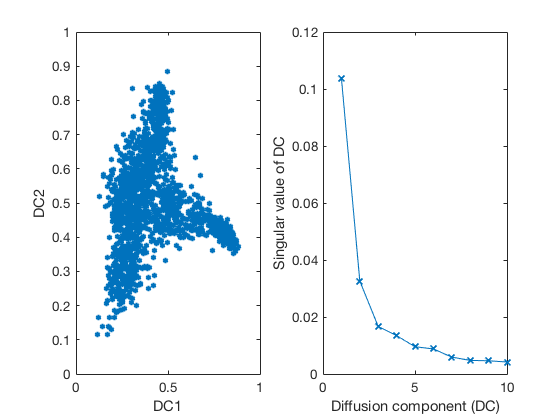

In [8]:
global dmParams 
dmParams = [10, Inf]; 
[dc, dcSig] = DiffusionMap_wNewData( scdata', [], dmParams(1), 0.5, dmParams(2) );
dc = dc_normalize(dc, 2);    % Normalize Diffusion Component to [0 1]
save( filename, 'dc', 'dcSig' ,'-append' ) 
figure; subplot( 1, 2, 1 ); f1=plot( dc(:,1), dc(:,2), 'o', 'markersize', 3); set(f1, 'markerfacecolor', get(f1, 'color'));xlim( [0 1] ); ylim( [0 1]); xlabel('DC1'); ylabel('DC2')
subplot( 1, 2, 2 ); plot( dcSig, '-x' ); xlabel('Diffusion component (DC)'); ylabel('Singular value of DC')

###### PDE grid and differentiation matrix 

In [10]:
global N N1 dx 
N = [100 125]; 
Compute_systemMatrix( N ); 

###### Compute homeostasis distribution 

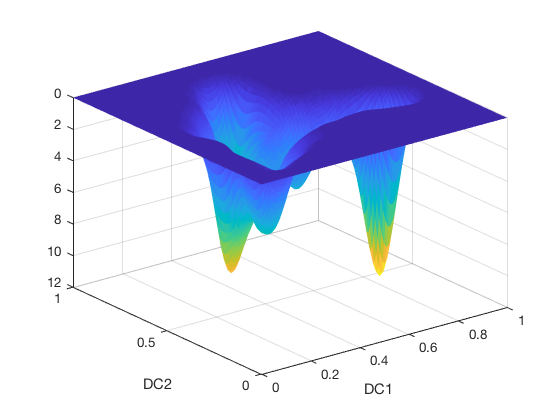

In [11]:
global xx yy 
[YY,XX] = meshgrid(yy,xx); 
[uHS,~,~] = ksdensity( [dc(:,1:2)], [XX(:),YY(:)], 'bandwidth', [0.03 0.03] );
uHS = reshape( uHS, N1(1), N1(2) ); 
figure; surf( XX, YY, uHS, 'linestyle','none' ); set(gca, 'Zdir', 'reverse'); xlabel('DC1'); ylabel('DC2'); 

###### Compute PDE coefficients by Interpolation 

In [12]:
set_system_paramters; 
Compute_systemCoeff( ntest, uHS ); 

###### Solve PDE in Normal condition 

In [13]:
% Set Initial Condition 
uinit = IC_2Dsp( 0.5, uHS*0.05, ntest ); 
uinit = BC_2Dsp( uinit );

% Solve PDE with Runge Kutta 4th  
T = 5; dt = 0.001; Tstep = 1; 
[uPlot, nCellPlot] = Time_Integ_RK4( @Compute_du_2Dsp, @BC_2Dsp, uinit, T, dt, Tstep ); 

Elapsed time is 23.791852 seconds.



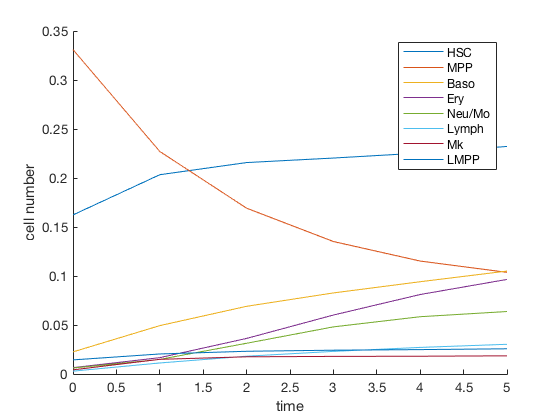

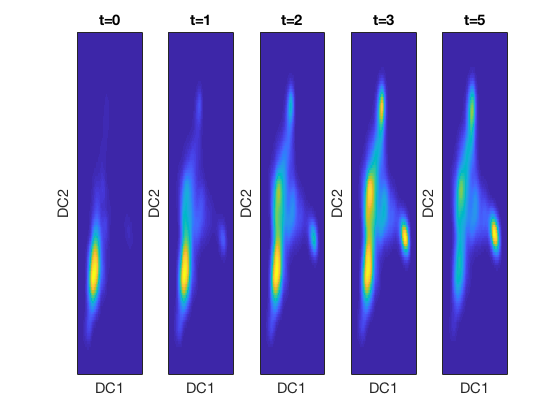

In [14]:
% Plot results 
figure; 
for nT = 1:(T/Tstep+1)
    subplot( 1, 5, min(nT,5) ); 
    imagesc( squeeze(uPlot(:,:,nT))' ); 
    set(gca, 'YDir','normal');  title( strcat( 't=', int2str(nT-1) )); 
    xlabel( 'DC1' ); xticks( [] ); ylabel( 'DC2' ); yticks( [] ); 
end
figure; hold on; 
plot( [0:Tstep:T], nCellPlot' ); 
xlabel( 'time' ); ylabel( 'cell number' ); 
legend( { 'MPP' 'HSC' 'Baso' 'Ery' 'Neu/Mo'  'Lymph' 'Mk'  'LMPP'  } ); 

###### Solve PDE in AML condition (Over proliferation of MEP (Ery) population) 

In [15]:
Update_AML( ntest )

%% IC for AML case - initiate from homoestasis
uinit = IC_2Dsp( 0, uHS, ntest ); 
uinit = BC_2Dsp( uinit );

T = 10; dt = 0.001; Tstep = 0.1;
[uPlot, nCellPlot] = Time_Integ_RK4( @Compute_du_2Dsp, @BC_2Dsp, uinit, T, dt, Tstep ); 

Elapsed time is 47.272506 seconds.



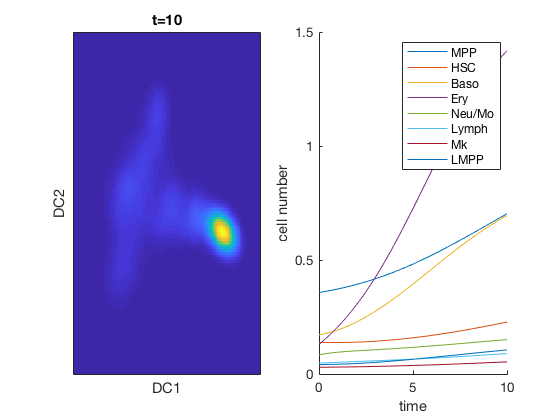

In [17]:
figure; 
subplot( 1, 2, 1 ); uPlot = squeeze(uPlot(:,:,end)); 
imagesc( uPlot' ); 
    set(gca, 'YDir','normal');  title( strcat( 't=', int2str(T) )); 
    xlabel( 'DC1' ); xticks( [] ); ylabel( 'DC2' ); yticks( [] ); 
subplot( 1, 2, 2 ); hold on;  
plot( [0:Tstep:T], nCellPlot' ); 
    xlabel( 'time' ); ylabel( 'cell number' ); 
    legend( {  'MPP' 'HSC' 'Baso' 'Ery' 'Neu/Mo'  'Lymph' 'Mk'  'LMPP'  } ); 

###### Solve PDE in AML condition - 1  (Gene alterations) 

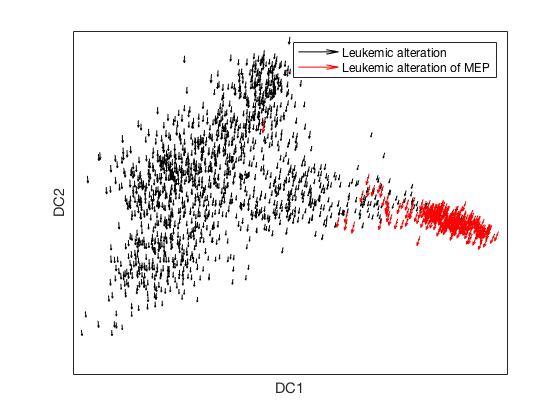

In [56]:
%% Load and compute gene alteration info - returns vector of alterations 
[vec, ~, ~] = Compute_Gene_Perturbation( ntest ); 
figure; quiver( dc(:,1), dc(:,2), vec(:,1), vec(:,2), 'black' ); xlabel( 'DC1' ); xticks( [] ); ylabel( 'DC2' ); yticks( [] ); 

ind = find( ncluster == 4 ); 
caml = 5;
hold on; quiver( dc(ind,1), dc(ind,2), caml*vec(ind,1), caml*vec(ind,2), 'r' ); 
legend( {'Leukemic alteration', 'Leukemic alteration of MEP '} )

In [46]:
global cDiff caml  
cDiff=0.1^3; 
caml = 5; 
Compute_systemCoeff( ntest, uHS ); 
Update_AML2( ntest ); 

T = 4; dt = 0.001; Tstep = 2; 
[uPlot, nCellPlot] = Time_Integ_RK4( @Compute_du_2Dsp, @BC_2Dsp, uinit, T, dt, Tstep ); 

Elapsed time is 19.931476 seconds.



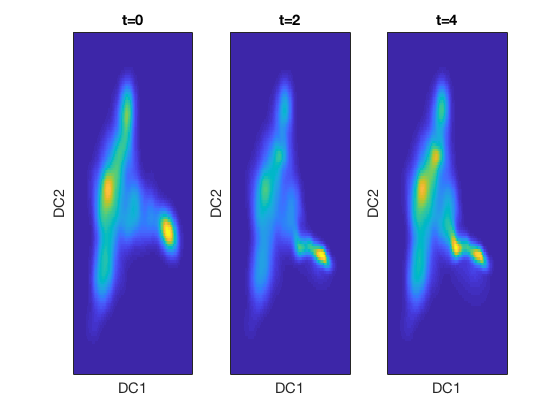

In [49]:
figure; 
for nT = 1:(T/Tstep+1)
    subplot( 1, 3, (min(nT,3)) ); 
    imagesc( squeeze(uPlot(:,:,nT))' ); 
    set(gca, 'YDir','normal');  title( strcat( 't=', int2str(nT*Tstep-2) )); 
    xlabel( 'DC1' ); xticks( [] ); ylabel( 'DC2' ); yticks( [] ); 
end

###### Solve PDE in AML condition - 2

In [61]:
Compute_systemCoeff( ntest, uHS ); 
Update_AML3( ntest ); 

T = 10; dt = 0.001; Tstep = 5; 
[uPlot, nCellPlot] = Time_Integ_RK4( @Compute_du_2Dsp, @BC_2Dsp, uinit, T, dt, Tstep ); 

Elapsed time is 49.416677 seconds.



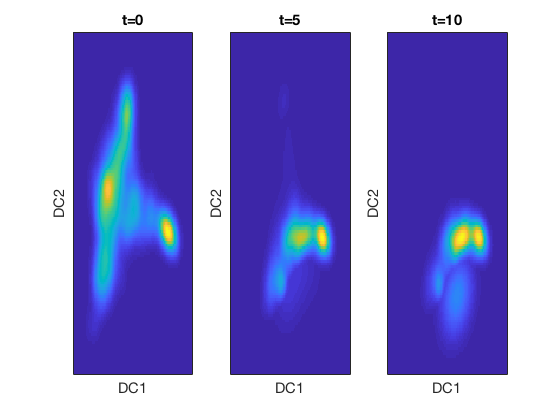

In [63]:
figure; imagesc( squeeze(uPlot(:,:,end))' ); 
for nT = 1:(T/Tstep+1)
    subplot( 1, 3, (min(nT,3)) ); 
    imagesc( squeeze(uPlot(:,:,nT))' ); 
    set(gca, 'YDir','normal');  title( strcat( 't=', int2str(nT*Tstep-5) )); 
    xlabel( 'DC1' ); xticks( [] ); ylabel( 'DC2' ); yticks( [] ); 
end 